# simple convolution network

## image to column

In [1]:
import sys, os
sys.path.append(os.pardir)
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

In [2]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[ 33.  57.  41.  60.]
   [ 19.  35.  22.  80.]
   [ 75.  70.  15.   4.]
   [ 32.  75.   5.  24.]]]


 [[[ 13.  48.  22.  86.]
   [ 85.  35.  37.  41.]
   [ 62.   9.  76.  77.]
   [ 15.  69.  57.  63.]]]]
============= col ==============
 [[ 33.  57.  41.  19.  35.  22.  75.  70.  15.]
 [ 57.  41.  60.  35.  22.  80.  70.  15.   4.]
 [ 19.  35.  22.  75.  70.  15.  32.  75.   5.]
 [ 35.  22.  80.  70.  15.   4.  75.   5.  24.]
 [ 13.  48.  22.  85.  35.  37.  62.   9.  76.]
 [ 48.  22.  86.  35.  37.  41.   9.  76.  77.]
 [ 85.  35.  37.  62.   9.  76.  15.  69.  57.]
 [ 35.  37.  41.   9.  76.  77.  69.  57.  63.]]


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] im2colの処理を確認しよう - (1)
・関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう<br>


In [3]:
import sys, os
sys.path.append(os.pardir)
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    ## 【レポート提出者変更】
    #col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

In [4]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[ 41.  59.  17.  59.]
   [ 75.  91.  61.  66.]
   [ 64.  27.   5.  91.]
   [ 87.  51.  11.  19.]]]


 [[[  0.  54.  86.  51.]
   [ 43.  59.  24.  82.]
   [ 72.   3.  60.  20.]
   [ 37.  55.  15.  66.]]]]
============= col ==============
 [[ 41.  59.  75.  91.  59.  17.  91.  61.  17.]
 [ 59.  61.  66.  75.  91.  64.  27.  91.  61.]
 [ 27.   5.  61.  66.   5.  91.  64.  27.  87.]
 [ 51.  27.   5.  51.  11.   5.  91.  11.  19.]
 [  0.  54.  43.  59.  54.  86.  59.  24.  86.]
 [ 51.  24.  82.  43.  59.  72.   3.  59.  24.]
 [  3.  60.  24.  82.  60.  20.  72.   3.  37.]
 [ 55.   3.  60.  55.  15.  60.  20.  15.  66.]]


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] im2colの処理を確認しよう - (2)
・input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう


In [5]:
import sys, os
sys.path.append(os.pardir)
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

In [6]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')

## original
#filter_h = 3
#filter_w = 3
#stride = 1
#pad = 0

filter_h = 2  ## 元の画像サイズ+パディングが最大値
filter_w = 2  ## 〃
stride = 1
pad = 0

col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[ 56.  26.  97.  42.]
   [ 77.   1.  96.  40.]
   [ 42.  40.  46.  67.]
   [ 51.  75.  28.  94.]]]


 [[[ 38.  93.  13.  30.]
   [ 11.  47.  12.  48.]
   [ 73.  59.  38.  22.]
   [ 96.  20.  68.  72.]]]]
============= col ==============
 [[ 56.  26.  77.   1.]
 [ 26.  97.   1.  96.]
 [ 97.  42.  96.  40.]
 [ 77.   1.  42.  40.]
 [  1.  96.  40.  46.]
 [ 96.  40.  46.  67.]
 [ 42.  40.  51.  75.]
 [ 40.  46.  75.  28.]
 [ 46.  67.  28.  94.]
 [ 38.  93.  11.  47.]
 [ 93.  13.  47.  12.]
 [ 13.  30.  12.  48.]
 [ 11.  47.  73.  59.]
 [ 47.  12.  59.  38.]
 [ 12.  48.  38.  22.]
 [ 73.  59.  96.  20.]
 [ 59.  38.  20.  68.]
 [ 38.  22.  68.  72.]]


## column to image

In [7]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## col2imの処理を確認しよう
・im2colの確認で出力したcolをimageに変換して確認しよう

In [8]:
image = col2im(col, input_data.shape, filter_h, filter_w, stride, pad)
print(image)

[[[[  56.   52.  194.   42.]
   [ 154.    4.  384.   80.]
   [  84.  160.  184.  134.]
   [  51.  150.   56.   94.]]]


 [[[  38.  186.   26.   30.]
   [  22.  188.   48.   96.]
   [ 146.  236.  152.   44.]
   [  96.   40.  136.   72.]]]]


## convolution class

In [9]:
class Convolution:
    # W: フィルター, b: バイアス
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # フィルター・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        # dcolを画像データに変換
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


## pooling class

In [10]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに最大値を求める
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## sinple convolution network class

In [11]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 0010. 正答率(トレーニング) = 0.4426 正答率(テスト) = 0.4160
Generation: 0020. 正答率(トレーニング) = 0.6360 正答率(テスト) = 0.6150
Generation: 0030. 正答率(トレーニング) = 0.7602 正答率(テスト) = 0.7130
Generation: 0040. 正答率(トレーニング) = 0.7958 正答率(テスト) = 0.7510
Generation: 0050. 正答率(トレーニング) = 0.8250 正答率(テスト) = 0.7900
Generation: 0060. 正答率(トレーニング) = 0.8690 正答率(テスト) = 0.8430
Generation: 0070. 正答率(トレーニング) = 0.8858 正答率(テスト) = 0.8480
Generation: 0080. 正答率(トレーニング) = 0.8922 正答率(テスト) = 0.8560
Generation: 0090. 正答率(トレーニング) = 0.8794 正答率(テスト) = 0.8350
Generation: 0100. 正答率(トレーニング) = 0.9014 正答率(テスト) = 0.8760
Generation: 0110. 正答率(トレーニング) = 0.9004 正答率(テスト) = 0.8740
Generation: 0120. 正答率(トレーニング) = 0.9166 正答率(テスト) = 0.8930
Generation: 0130. 正答率(トレーニング) = 0.9184 正答率(テスト) = 0.8810
Generation: 0140. 正答率(トレーニング) = 0.9068 正答率(テスト) = 0.8870
Generation: 0150. 正答率(トレーニング) = 0.9178 正答率(テスト) = 0.8960
Generation: 0160. 正答率(トレーニング) = 0.9232 正答率(テスト) = 0.8770
Generation: 0170. 正答率(トレーニング) = 0.9210 正答率(テスト) = 0.9030
Generation: 0180. 正答率

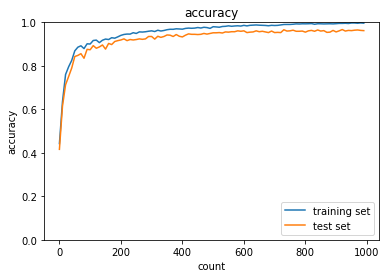

In [12]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]
#x_train, d_train = x_train[:500], d_train[:500]  ## 【レポート提出者追記】0.1倍の個数だと過学習してしまった
#x_test, d_test = x_test[:100], d_test[:100]



network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        ## 【レポート提出者変更】
        #print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        #print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        print('Generation: {:0=4}. 正答率(トレーニング) = {:1.4f} 正答率(テスト) = {:1.4f}'.format(i+1, accr_train, accr_test))

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()